In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
plt.rcParams.update({'font.size': 14})
import scipy
from utilities import convert2D_to_1D, error, prepare_phi_and_S, convert1D_to_2D, plot_phi,residual, matrixA, forward_substitution, backward_substitution

In [2]:
def NZA(A):
    """

    :param A: Banded Matrix A
    :return: Sparsity pattern, if the element is not zero, at the index of that element, NZA[i, j] = 1
    """
    NZA = np.zeros(A.shape)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i, j] != 0:
                NZA[i, j] = 1

    return NZA


def ILU0(NZA, AA):
    """

    :param NZA: Sparsity pattern
    :param AA: Banded Matrix A
    :return: Decomposed matrix A --> [L] [U] = [A]
    """
    L = np.eye(NZA.shape[0])
    U = np.zeros(NZA.shape)
    K = NZA.shape[0]

    for k in tqdm(range(K - 1)):
        for i in range(k+1, K):

            if NZA[i, k] == 1:
                AA[i, k] = AA[i, k] / AA[k, k]

            for j in range(k+1, K):
                if NZA[i, j] == 1:
                    AA[i, j] = AA[i, j] + AA[i, k] * AA[k, j]

    for i in range(K):
        for j in range(i, K):
            U[i, j] = AA[i, j]

        for j in range(i):
            L[i, j] = AA[i, j]

    return L, U


def matmul_between_transpose_and_normal(mat1, mat2, N, M):
    """

    :param mat1: the matrix that will be transposed
    :param mat2: normal matrix
    :param N: The number of grid in x-axis
    :param M: The number of grid in y-axis
    :return: A scalar: [mat1].T @ [mat2]
    """
    output = 0
    for i in range(1, N - 1):
        for j in range(1, M - 1):
            k = (j - 1) * N + i
            output = output + mat1[k] * mat2[k]

    return output


def Compute_Rm(L, U, R):
    """
    [ M ] [ Rm ] = [ R ]
    [ M ] = [ L ] [ U ]
    [ L ] [ U ] [ Rm ] = [ R ]
    [ U ] [ Rm ] = [ Y ]
    [ L ] [ Y ] = [ R ]

    # Compute above steps from last eqn to top eqn without using matrix
    """
    Y = backward_substitution(L, R)

    Rm = forward_substitution(U, Y)
    # Y = scipy.sparse.linalg.spsolve_triangular(L, R, lower=True)
    # Rm = scipy.sparse.linalg.spsolve_triangular(U, Y, lower=False)
    # Rm = L@U@R
    return Rm

In [3]:
def prepare_phi_and_S(Nx, Ny, phi, L, H, convert_to_K=False):
    # Generate RHS source terms matrix and unknowns 'phi' with Dirichlet BCs
    if convert_to_K:
        S = np.zeros((Nx * Ny))
        phi = np.zeros((Nx * Ny))
    else:
        S = np.zeros((Nx, Ny))
        phi = np.zeros((Nx, Ny))
    dx = L / (Nx - 1)  # Grid size
    dy = H / (Ny - 1)  # Grid size
    # RHS source terms
    for i in range(Nx):
        for j in range(Ny):
            x = i * dx
            y = j * dy

            source = 50000*np.exp(-50*((1-x)**2+y**2))*(100*((1-x)**2+y**2)-2)

            if convert_to_K:
                k = (j - 1) * Nx + i
                S[k] = source
            else:
                S[i, j] = source

    ## Right BC
    i = Nx - 1
    for j in range(1, Ny - 1):

        x = i * dx
        y = j * dy
        phiR = 100*(1-y) + 500*np.exp(-50*y**2)

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiR
            S[k] = phiR
        else:
            phi[i, j] = phiR
            S[i, j] = phiR

    ## left BC
    i = 0
    for j in range(1, Ny - 1):

        x = i * dx
        y = j * dy

        phiL = 500*np.exp(-50*(1+y**2))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiL
            S[k] = phiL
        else:
            phi[i, j] = phiL
            S[i, j] = phiL

    ## Bottom BC
    j = 0
    for i in range(Nx):

        x = i * dx
        y = j * dy

        phiB = 100*x + 500*np.exp(-50*(1-x)**2)
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiB
            S[k] = phiB
        else:
            phi[i, j] = phiB
            S[i, j] = phiB

    ## Top BC
    j = Ny - 1
    for i in range(Nx):

        x = i * dx
        y = j * dy

        phiT = 500*np.exp(-50*((1-x)**2+1))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiT
            S[k] = phiT
        else:
            phi[i, j] = phiT
            S[i, j] = phiT

    return phi, S

In [4]:

Nx = 61
Ny = 61
Length = 1  # length
Height = 1
phi = np.zeros((Nx * Ny))

dx = Length / (Nx - 1)  # Grid size
dy = Height / (Ny - 1)  # Grid size

tol = 1e-6

aE = 1 / dx ** 2
aW = 1 / dx ** 2
aN = 1 / dy ** 2
aS = 1 / dy ** 2
a0 = -(2 / dx ** 2 + 2 / dy ** 2)

# Same coefficient name as Stone's method
K = Nx * Ny
B = np.full(K, aS)
D = np.full(K, aW)
E = np.full(K, a0)
F = np.full(K, aE)
H = np.full(K, aN)

phi, S = prepare_phi_and_S(Nx, Ny, phi, Length, Height, convert_to_K=True)

A = matrixA(Nx, Ny, dx, dy)
AA = np.copy(A)
nza = NZA(AA)
L, U = ILU0(nza, AA)

  0%|          | 18/3720 [00:36<2:05:49,  2.04s/it]


KeyboardInterrupt: 

In [ ]:

# decomposition = scipy.sparse.linalg.spilu(A)
# L = decomposition.L
# U = decomposition.U
start = time.time()
# Initial residual
R2_old, Rsum_old, R_old = residual(Nx, Ny, phi, S, aE, aW, aN, aS, a0, convert=True)

# Modified residual Rm
Rm_old = Compute_Rm(L, U, R_old)

# Step 3: Set the initial search direction vector equal to the residual vector
D0 = Rm_old

for _ in tqdm(range(100000)):

    # Compute new alpha
    # Compute A@D
    ad = np.zeros(Nx * Ny)
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            k = (j - 1) * Nx + i
            # k = K-1

            ad[k] = E[k] * D0[k] + F[k] * D0[k + 1] + H[k] * D0[k + Nx] + D[k] * D0[k - 1] + B[k] * D0[k - Nx]

    Dt_ad = 0
    for k in range(Nx*Ny):
        Dt_ad = Dt_ad + D0[k] * ad[k]

    alpha_new = Rsum_old / Dt_ad

    phi = phi + alpha_new * D0

    # Compute residual
    R2_new, Rsum_new, R_new = residual(Nx, Ny, phi, S, aE, aW, aN, aS, a0, convert=True)


    # Compute new modified residual
    Rm_new = Compute_Rm(L, U, R_new)

    # Compute Beta, beta = [ { R_new.T } @ {Rm_new} ]/ [ { R_old.T } @ {Rm_old} ]
    num = matmul_between_transpose_and_normal(R_new, Rm_new, Nx, Ny)
    den = matmul_between_transpose_and_normal(R_old, Rm_old, Nx, Ny)
    #
    # num = R_new.T @ Rm_new
    # den = R.T @ Rm
    beta = num / den

    # Update search direction vector
    D0 = Rm_new + beta * D0

    # Update old residual vector
    Rsum_old = Rsum_new
    R2_old = R2_new
    R_old = R_new
    Rm_old = Rm_new

    if _ % 300 == 0:
        clear_output(True)
        print(f'alpha: {alpha_new}')
        print("Residual: ", R2_new)

    if R2_new < tol:
        print('Converged! Residual: ', R2_new, 'Time elapsed: ', time.time() - start)
        break


  0%|          | 66/100000 [00:00<05:03, 329.23it/s]

alpha: -0.0009405020356129802
Residual:  261273.02668198643


  0%|          | 75/100000 [00:00<05:14, 317.40it/s]

Converged! Residual:  8.261510397483641e-07 Time elapsed:  0.2413029670715332


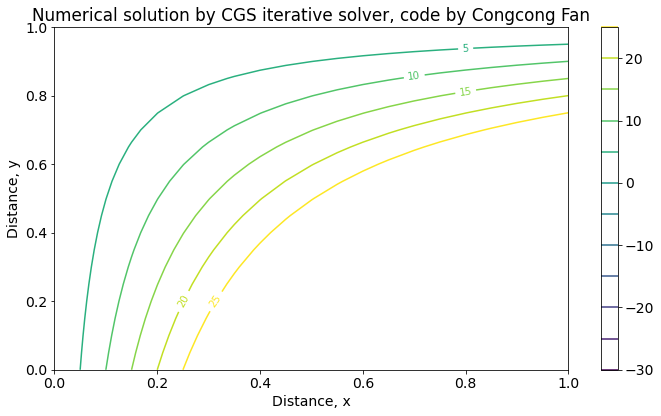

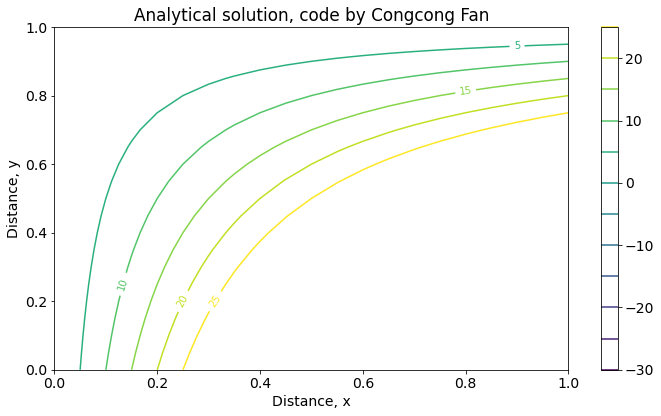

In [ ]:
# Analytical solution
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
phi_A = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        
        phi_A[i,j] = 500*np.exp(-50*((1-x[i])**2+y[j]**2)) + 100*x[i]*(1-y[j])

plot_phi(phi, phi_A, Nx,Ny, 'CGS', convert=True)

In [ ]:
L = ilu.L.A
U = ilu.U.toarray()

NameError: name 'ilu' is not defined